# CS224W Final Project Code
# Project by Matthew Kaplan, Avery Rogers, Guillermo Wenrich

Unless stated in inline comments, all code below courtesy of Authors Fabrizio Frasca, Emanuele Rossi, Davide Eynard, Ben Chamberlain, Michael Bronstein, Federico Monti. Adapted to PyTorch Geometric for running in Python Notebook computing environment by Matthew Kaplan, Guillermo Wenrich, and Avery Rogers.

Link to Code GitHub: https://github.com/dmlc/dgl/tree/master/examples/pytorch/ogb/sign

Link to Model Paper: https://arxiv.org/abs/2004.11198

Citation:
Frasca, F., Rossi, E., Eynard, D., Chamberlain, B., Bronstein, M., & Monti, F. (2020b). SIGN: Scalable inception graph neural networks. Retrieved from https://arxiv.org/abs/2004.11198

**Instructions: Run all of the cells in order to ensure that all functions are loaded before running the final 3 cells. Mounting your Google Drive is optional, but was used by Matthew, Guillermo, and Avery to load the dataset from a Drive folder instead of redownloading everytime.**

In [ ]:
# Added by Matthew Kaplan, Guillermo Wenrich, Avery Rogers for downloading dataset.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Colab does not have the PyG libraries and Open Graph Benchmark library installed by default. So, we pip install them first.

In [ ]:
# Our code: necessary installs for code.
!pip install ogb
!pip install -q git+https://github.com/snap-stanford/deepsnap.git

!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-geometric
# !pip install -q git+https://github.com/snap-stanford/deepsnap.git
# !pip install -U -q PyDrive

Looking in links: https://data.dgl.ai/wheels/repo.html
Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html
Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html


Now, lets import the necessary libraries to implement the SIGN model using PyTorch and PyG.

In [ ]:
# Imports
import torch
import numpy as np
# Original authors use dgl as opposed to networkx
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
import argparse
import time
import torch.nn as nn
import pickle as pkl

# Our Code: Imports Necessary for adaptation to PyG
import torch_geometric
import torch_scatter
from torch_geometric.data import DataLoader
from torch_sparse import SparseTensor, matmul

Using backend: pytorch


This is the evaluator to measure model performance, as described under the performance evaluator section at this link: https://ogb.stanford.edu/docs/nodeprop/ 

In [ ]:
# This is the OGB evaluator function provided by the original creators
# of the OGB dataset. Function authored by original authors to 
# use evaluator evaluate accuracy on train, val, test sets.
def get_ogb_evaluator(dataset):
    """
    Get evaluator from Open Graph Benchmark based on dataset
    """
    evaluator = Evaluator(name=dataset)
    return lambda preds, labels: evaluator.eval({
        "y_true": labels.view(-1, 1),
        "y_pred": preds.view(-1, 1),
    })["acc"]

This function loads the dataset. **Note: when running this yourself, make sure that the lines**

*dataset = PygNodePropPredDataset(name=name)*

*split_idx = dataset.get_idx_split()*

**are uncommented while the two lines below using pkl.load are erased or commented out.**

In [ ]:
# Function to load the ogbn-products. Part of original Python script
# but adapted by Matthew, Avery, and Guillermo to only support ogbn-products
# dataset.
def load_dataset(name, device):
    """
    Load dataset and move graph and features to device
    """
    if name != "ogbn-products":
        raise RuntimeError(f"Dataset {name} is not supported. Only supported dataset is ogbn-products.")

    # --------------------------------------------------------------------------------------------------------
    
    # TODO: UNCOMMENT THESE TWO LINES (THESE ARE THE LINES THAT SHOULD RUN)
    dataset = PygNodePropPredDataset(name=name) # Normal code used to load dataset in local environment.
    split_idx = dataset.get_idx_split() # Normal code to then extract train, val, test indices in local environment

    # --------------------------------------------------------------------------------------------------------

    # --------------------------------------------------------------------------------------------------------

    # Matthew, Avery, and Guillermo fix: Use a pickle dumped file of the dataset and dictionary
    # outlining train, validation, and test indices, load this from our Google Drive folder.
    # To reproduce, simply run the two lines of code commented above instead of these 2 lines.

    # TODO: COMMENT OUT THESE LINES OF CODE (THESE SHOULD NOT RUN).
    # dataset = pkl.load(open('/content/drive/MyDrive/CS224W/CS224W Project/pyg_ogbn_products_dataset.pkl', 'rb'))
    # split_idx = pkl.load(open('/content/drive/MyDrive/CS224W/CS224W Project/pyg_ogbn_products_idx.pkl', 'rb'))
    
    # --------------------------------------------------------------------------------------------------------
    
    train_nid = split_idx["train"]
    val_nid = split_idx["valid"]
    test_nid = split_idx["test"]
    graph = dataset[0]
    # We have code to put as a float and gather dataset statistics in PyG.
    graph.x = graph.x.type(torch.float32)
    # graph = graph.to(device)
    print(graph)
    # Cast features to floats.
    n_classes = dataset.num_classes
    # Flatten labels array.
    labels = graph.y.squeeze() #labels = labels.squeeze()
    evaluator = get_ogb_evaluator(name)

    # Print relevant graph statistics.
    print(f"# Nodes: {graph.num_nodes}\n"
          f"# Edges: {graph.num_edges}\n"
          f"# Train: {len(train_nid)}\n"
          f"# Val: {len(val_nid)}\n"
          f"# Test: {len(test_nid)}\n"
          f"# Classes: {n_classes}")

    return graph, labels, n_classes, train_nid, val_nid, test_nid, evaluator

The FeedForwardNet model is a learnable MLP with PReLU and Dropout nonlinearities. When considering equation (4) from the original paper here (Frasca et al. 2020):

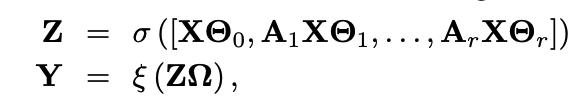

This model denotes the learnable parameters $\Theta_0, \dots \Theta_r$, as well as $\Omega$.

In [ ]:
# This is the feed forward net. The architecture is as follows:
# For num_layers - 1 it's Linear --> PReLU --> Dropout, then a final linear layer.
class FeedForwardNet(nn.Module):
    def __init__(self, in_feats, hidden, out_feats, n_layers, dropout):
        super(FeedForwardNet, self).__init__()
        self.layers = nn.ModuleList()
        self.n_layers = n_layers
        # 2 cases. If num layers is 1 just 1 linear layer from in --> out.
        # Else, you need in --> hidden, then num_layers - 2 hidden --> hidden
        # linear transformations, then a final hidden --> out linear layer.
        if n_layers == 1:
            self.layers.append(nn.Linear(in_feats, out_feats))
        else:
            self.layers.append(nn.Linear(in_feats, hidden))
            for i in range(n_layers - 2):
                self.layers.append(nn.Linear(hidden, hidden))
            self.layers.append(nn.Linear(hidden, out_feats))
        # In case of num layers - 1 we of course need non linearities.
        if self.n_layers > 1:
            self.prelu = nn.PReLU()
            self.dropout = nn.Dropout(dropout)
        self.reset_parameters()

    def reset_parameters(self):
        gain = nn.init.calculate_gain("relu")
        for layer in self.layers:
            nn.init.xavier_uniform_(layer.weight, gain=gain)
            nn.init.zeros_(layer.bias)

    def forward(self, x):
        for layer_id, layer in enumerate(self.layers):
            # Linear
            x = layer(x)
            # If not final layer add PReLU --> Dropout
            if layer_id < self.n_layers - 1:
                x = self.dropout(self.prelu(x))
        return x

Here is the full SIGN model, which describes the following architecture (Frasca et al. 2020):

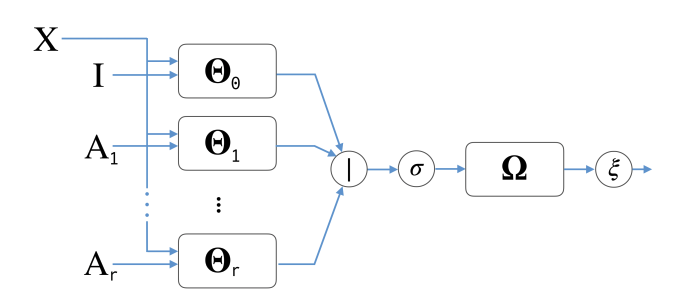

Which takes an array of inputs $[X, A_1X, \dots, A_rX]$ where $A_iX$ denotes the mean-aggregated embeddings with a receptive field of the ith-hop neighborhood. The model uses PReLU and Dropout Nonlinearities, and the learnable parameters are represented by the FeedForwardNet class above.

In [ ]:
# This is the SIGN Model, which can be seen as a wrapper over the feed forward
# net with more features.
class SIGN(nn.Module):
    def __init__(self, in_feats, hidden, out_feats, num_hops, n_layers,
                 dropout, input_drop):
        super(SIGN, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.prelu = nn.PReLU()
        self.inception_ffs = nn.ModuleList()
        self.input_drop = nn.Dropout(input_drop)
        for hop in range(num_hops):
            self.inception_ffs.append(
                FeedForwardNet(in_feats, hidden, hidden, n_layers, dropout))
        self.project = FeedForwardNet(num_hops * hidden, hidden, out_feats,
                                      n_layers, dropout)

    def forward(self, feats):
        # Each element in feats is the r-hop mean aggregated features.
        # Thus, feats holds input dropped mean aggregated features in the 
        # 1 --> r hop neighborhoods.
        feats = [self.input_drop(feat) for feat in feats]
        hidden = []
        # Now, send the features through the feed forward net (Think of this as
        # the Theta_0 --> Theta_r matricies defined in equation (4) of the paper.)
        for feat, ff in zip(feats, self.inception_ffs):
            hidden.append(ff(feat))
        # Now, concatenate the A * X * Theta_1, ..., A * X * Theta_r (torch.cat),
        # send them through nonlinearity (prelu and dropout) to get Z as seen
        # in equation (4) of the paper. Then, send them through a feed forward
        # net, to get Y as seen in equation (4) of the paper.
        out = self.project(self.dropout(self.prelu(torch.cat(hidden, dim=-1))))
        return out

    def reset_parameters(self):
        for ff in self.inception_ffs:
            ff.reset_parameters()
        self.project.reset_parameters()

In [ ]:
# Get the number of parameters in our model.
def get_n_params(model):
    pp = 0
    for p in list(model.parameters()):
        nn = 1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

Below is the PyG implementation to obtain the mean aggregated neighbor embeddings. We leverage PyG's SparseTensor library for a memory efficient implementation that stays within Cuda and RAM usage limits on Colab.

In [ ]:
# Authored by Matthew Kaplan, Guillermo Wenrich, and Avery Rogers
# This model performs 1 round of mean aggregation of neighbor embeddings.
# Due to memory limitations and the large graph, we leverage PyTorch Geometric's
# Sparse Tensor library to perform mean aggregation efficiently.
class AggregationLayer(torch_geometric.nn.conv.MessagePassing):
    
    def __init__(self):  
        super(AggregationLayer, self).__init__(aggr='mean')

    def forward(self, x, edge_index, size = None):
        return self.propagate(edge_index, x=x, size=size)

    def message(self, x_j):
        return x_j
    
    def message_and_aggregate(self, edge_index, x):
        return matmul(edge_index, x, reduce = self.aggr)

Given $X$ represented by the variable $graph$, this function returns an array $res$ containing $[X, A_1X, \dots, A_rX]$ where $A_iX$ is the mean aggregated neighbor embeddings with a receptive field of the ith hop neighborhood.

Here, $r$ is determined by $args.R$ which we set in below cells. We could only max out at $args.R = 2$, else we would exhaust Cuda memory.

In [ ]:
# Compute the args.R hop mean neighbor aggregated features.
# Uses our declared neighbor aggregation class and SparseTensor
# features to allow for this computation in Colab environment.
def neighbor_average_features(graph, args):
    model = AggregationLayer()
    graph.x = graph.x.to(device)
    adj = SparseTensor(row=graph.edge_index[0], col=graph.edge_index[1]).to(device)
    res = [graph.x]
    for hop in range(1, args.R + 1):
        # Get the most recent mean aggregated embeddings (or default features).
        x = res[-1]
        # Send it through 1 round of mean aggregation and append to res.
        res.append(model(x, adj.t()))
    return res

The below function calls the necessary functions above to load the data and obtain the neighbor aggregated features.

In [ ]:
def prepare_data(device, args):
    """
    Load dataset and compute neighbor-averaged node features used by SIGN model
    """
    data = load_dataset(args.dataset, device)
    # Undo the tuple returned.
    g, labels, n_classes, train_nid, val_nid, test_nid, evaluator = data
    # Get the number of in_features.
    in_feats = g.x.shape[1]
    # Get the neighbor aggregated features.
    feats = neighbor_average_features(g, args)
    # Send labels and indices to GPU if enabled.
    labels = labels.to(device)
    train_nid = train_nid.to(device)
    val_nid = val_nid.to(device)
    test_nid = test_nid.to(device)
    return feats, labels, in_feats, n_classes, \
        train_nid, val_nid, test_nid, evaluator


Classic PyTorch implementation for training and testing the model in batches.

In [ ]:
# Send batches forward and backwards through model.
# Very classic PyTorch train syntax.
def train(model, feats, labels, loss_fcn, optimizer, train_loader):
    model.train()
    device = labels.device
    for batch in train_loader:
        batch_feats = [x[batch].to(device) for x in feats]
        loss = loss_fcn(model(batch_feats), labels[batch])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
# Send batch through model for testing purposes.
# Classic evaluator PyTorch syntax but uses the Evaluator
# function defined in first real code cell under imports
def test(model, feats, labels, test_loader, evaluator,
         train_nid, val_nid, test_nid):
    model.eval()
    device = labels.device
    preds = []
    for batch in test_loader:
        batch_feats = [feat[batch].to(device) for feat in feats]
        preds.append(torch.argmax(model(batch_feats), dim=-1))
    # Concat mini-batch prediction results along node dimension
    preds = torch.cat(preds, dim=0)
    train_res = evaluator(preds[train_nid], labels[train_nid])
    val_res = evaluator(preds[val_nid], labels[val_nid])
    test_res = evaluator(preds[test_nid], labels[test_nid])
    return train_res, val_res, test_res

The run function calls the train and test functions appropriately for the given number of epochs and evaluates the model performance.

In [ ]:
# Run training and testing from start to finish through this function
def run(args, data, device):
    feats, labels, in_size, num_classes, \
        train_nid, val_nid, test_nid, evaluator = data
    # Dataloader automatically loads batch indices for an epoch.
    # Shuffle for train to get batch, do not shuffle for test
    # to get accurate test accuracy.
    train_loader = torch.utils.data.DataLoader(
        train_nid, batch_size=args.batch_size, shuffle=True, drop_last=False)
    test_loader = torch.utils.data.DataLoader(
        torch.arange(labels.shape[0]), batch_size=args.eval_batch_size,
        shuffle=False, drop_last=False)

    # Initialize model and optimizer for each run
    num_hops = args.R + 1
    model = SIGN(in_size, args.num_hidden, num_classes, num_hops,
                 args.ff_layer, args.dropout, args.input_dropout)
    model = model.to(device)
    print("# Params:", get_n_params(model))

    loss_fcn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr,
                                 weight_decay=args.weight_decay)

    # Start training
    best_epoch = 0
    best_val = 0
    best_test = 0
    for epoch in range(1, args.num_epochs + 1):
        print(f'Training Epoch {epoch}...')
        start = time.time()
        # Train the model for a whole epoch.
        train(model, feats, labels, loss_fcn, optimizer, train_loader)

        # Evaluate accuracy every eval_every epochs.
        if epoch % args.eval_every == 0:
            with torch.no_grad():
                acc = test(model, feats, labels, test_loader, evaluator,
                           train_nid, val_nid, test_nid)
            end = time.time()
            log = "Epoch {}, Time(s): {:.4f}, ".format(epoch, end - start)
            log += "Acc: Train {:.4f}, Val {:.4f}, Test {:.4f}".format(*acc)
            print(log)
            if acc[1] > best_val:
                best_epoch = epoch
                best_val = acc[1]
                best_test = acc[2]

    print("Best Epoch {}, Val {:.4f}, Test {:.4f}".format(
        best_epoch, best_val, best_test))
    return best_val, best_test

Below, instead of using an argument parser authored by the original authors which is utilized in .py files, we instead declare an argument class which takes in the desired arugments in the initialize function. This way, the syntax can remain while also integrating into a Python Notebook.

**Notes: The default argument parameters in the** *__init__* **function are identical to those of the original author. We change the parameters in the call to arg_parser at the bottom of the cell to make the code workable in a Google Colab GPU computing environment.** 

Feel free to change these parameters yourself, but beyond the default arguments we recommend:

$num\_epochs = 30$

$R = 2$

$batch\_size = 128$

$eval\_batch\_size = 256$

$num\_runs = 2$

In [ ]:
# --------------------------------------------------------------------------
# Authored code by Matthew, Avery, & Guillermo

# Substitute argument parser for args class (doesn't change syntax
# but allows for better integration into .ipynb file versus an .py file)
class arg_parser:

  def __init__(self, num_epochs=1000, num_hidden=512, R=5, lr=0.001,
               dataset='ogbn-products', dropout=0.5, weight_decay=0,
               eval_every=10, batch_size=50000, eval_batch_size=100000,
               ff_layer=2, input_dropout=0, num_runs=10):
    self.num_epochs = num_epochs
    self.num_hidden = num_hidden
    self.R = R
    self.lr = 0.001
    self.dataset = dataset
    self.dropout = dropout
    self.weight_decay = weight_decay
    self.eval_every = eval_every
    self.batch_size = batch_size
    self.eval_batch_size = eval_batch_size
    self.ff_layer = ff_layer
    self.input_dropout = input_dropout
    self.num_runs = num_runs
# --------------------------------------------------------------------------

# --------------------------------------------------------------------------

# TODO: ADD OR CHANGE ARGUMENTS IN THE ARG_PARSER CLASS AS YOU WISH BY CHANGING
# THE ARGUMENTS PASSED INTO THE ARG PARSER CLASS HERE. WE RECOMMEND THE DEFAULT
# ARGUMENTS AS WELL AS WHAT IS OUTLINED IN THE TEXT CELL ABOVE.
args = arg_parser(num_epochs=30, R=2, batch_size=128, eval_batch_size=256, num_runs=2)
# --------------------------------------------------------------------------

After runnning all cells above, we are finally ready to run the notebook. First, run this cell to activate Cuda as our device, load the data, and obtain our neighbor aggregated features.

In [ ]:
# ---------------------------------------------------------------
# Authored code by Matthew, Avery, & Guillermo

# Change to if GPU available.
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')
print(f'Device: {device}')

# ---------------------------------------------------------------

# ---------------------------------------------------------------
# Authored by original authors in paper above.

with torch.no_grad():
    data = prepare_data(device, args)
# ---------------------------------------------------------------

Device: cuda
Data(edge_index=[2, 123718280], x=[2449029, 100], y=[2449029, 1])
# Nodes: 2449029
# Edges: 123718280
# Train: 196615
# Val: 39323
# Test: 2213091
# Classes: 47


Now, run this cell to pass the data into the model, and train the model based on the argument parameters given above. After running this cell, record the final validation and testing accuracy by the model.

In [ ]:
# This rounds out the original main function.
val_accs = []
test_accs = []
# Num_Runs is how many times we start from scratch.
for i in range(args.num_runs):
    print(f"Run {i} start training")
    # Run the model, get the val and test accuracy at each go.
    best_val, best_test = run(args, data, device)
    val_accs.append(best_val)
    test_accs.append(best_test)

# Print the average val and test accuracies.
print(f"Average val accuracy: {np.mean(val_accs):.4f}, "
      f"std: {np.std(val_accs):.4f}")
print(f"Average test accuracy: {np.mean(test_accs):.4f}, "
      f"std: {np.std(test_accs):.4f}")

Run 0 start training
# Params: 1754164
Training Epoch 1...
Training Epoch 2...
Training Epoch 3...
Training Epoch 4...
Training Epoch 5...
Training Epoch 6...
Training Epoch 7...
Training Epoch 8...
Training Epoch 9...
Training Epoch 10...
Epoch 10, Time(s): 29.1186, Acc: Train 0.9375, Val 0.9168, Test 0.7635
Training Epoch 11...
Training Epoch 12...
Training Epoch 13...
Training Epoch 14...
Training Epoch 15...
Training Epoch 16...
Training Epoch 17...
Training Epoch 18...
Training Epoch 19...
Training Epoch 20...
Epoch 20, Time(s): 28.9915, Acc: Train 0.9405, Val 0.9167, Test 0.7568
Training Epoch 21...
Training Epoch 22...
Training Epoch 23...
Training Epoch 24...
Training Epoch 25...
Training Epoch 26...
Training Epoch 27...
Training Epoch 28...
Training Epoch 29...
Training Epoch 30...
Epoch 30, Time(s): 29.5031, Acc: Train 0.9432, Val 0.9189, Test 0.7530
Best Epoch 30, Val 0.9189, Test 0.7530
Run 1 start training
# Params: 1754164
Training Epoch 1...
Training Epoch 2...
Training 

Final Validation Accuracy: $91.91\%$

Final Test Accuracy: $75.95\%$